# <div align="center"> CNN可视化: Guided Backpropagation (GBP) </div>

## 导图

### 论文树图

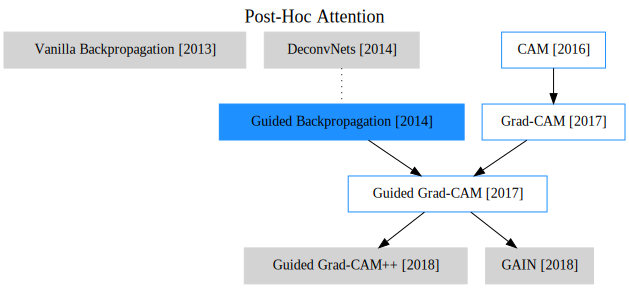

In [1]:
from IPython.display import display, HTML
from urllib import parse
from graphviz import Source
graph = '''digraph G {
    center = true  
    fontsize = 18  fontcolor = "#00000000"
    labelloc = top  labeljust = center
    label = "Post-Hoc Attention"
    node [shape=rectangle, color=dodgerblue]
    h [label="Vanilla Backpropagation [2013]" color=lightgray style=filled]
    g [label="DeconvNets [2014]" color=lightgray style=filled]
    a [label="Guided Backpropagation [2014]" style=filled]
    b [label="CAM [2016]"]
    c [label="Grad-CAM [2017]"]
    d [label="Guided Grad-CAM [2017]"]
    e [label="Guided Grad-CAM++ [2018]" color=lightgray style=filled]
    f [label="GAIN [2018]" color=lightgray style=filled]
    
    g -> a [style=dotted arrowhead=none]
    a -> d
    b -> c
    c -> d
    d -> e
    d -> f
}'''
# Source(graph)
HTML('<img src="data:image/svg+xml;utf8,{}"/>'.format(parse.quote(Source(graph)._repr_svg_())))

## 描述

给定一张已知分类(c)的图片, 输入到模型并且得到了高分($S_c$), 那么我们想知道这张图片的哪些像素对计算出高分起到关键作用, 这类问题属于显著图(Saliency Maps), 属于对已训练好的CNN模型进行可视化(Post-Hoc Attention), 有时Saliency Maps也是指Backpropagation, 因为都是对梯度的可视化, 梯度是通过反向传播计算出的, Saliency Maps就是对分类得分函数的求导.


### Vanilla Backpropagation (VBP)


TODO

### DevcovNets (Transposed Convolution)

TODO

### Guided Backpropagation (GBP)

TODO

## 模型

![](https://gitee.com/qrsforever/blog_source_assets/raw/master/AI/post-hoc/schematic_visual.png)

### Vanilla Backpropagation

```
             1 -1  5      
             2 -5 -7      
            -3  2  4      
                |
                |
                v
-2  0 -1     1  0  1    -2  3 -1
 6  0  0  =  1  0  0  x  6 -3  1
 0 -1  3     0  1  1     2 -1  3
```

### DevcovNets

```
            -2  3 -1
             6 -3  1    
             2 -1  3
                |
                |
                v
 0  3  0     0  1  0    -2  3 -1
 6  0  1  =  1  0  1  x  6 -3  1
 2  0  3     1  0  1     2 -1  3
```

### Guided Backpropagation

```
             1 -1  5    -2  3 -1   
             2 -5 -7     6 -3  1       
            -3  2  4     2 -1  3   
                |           |
                |           |
                v           v
 0  0  0     1  0  1     0  1  0    -2  3 -1   
 6  0  0  =  1  0  0  X  1  0  1  x  6 -3  1   
 0  0  3     0  1  1     1  0  1     2 -1  3 
```

- 线性模型:

> $$
  S_c(I) = \omega_c^T I + b_c
  $$
> 
> $\omega$里的元素值的大小直接影响S的得分.

- 非线性模型(CNN), 采用泰勒展开(一阶导)进行线性近似:

> $$
  \begin{align*}
  S_c(I) &\approx \omega_c^T I + b_c \\
  \omega &= \left. \dfrac{\partial S_c}{\partial I} \right|_{I_0}
  \end{align*}
  $$
> 泰勒公式补充:
> $$
  f(x) = \dfrac{f(a)}{0!} + \dfrac{f'(a)}{1!}(x-a) + \dfrac{f''(a)}{2!}(x-a)^2 + \cdots + \dfrac{f^{(n)}(a)}{n!}(x-a)^n + R_n(x)
  $$


符号|描述
:--:|:----
<img width=200/>|<img width=400/>
$S_c()$|分类c的得分函数
$I$|输入图片pixes
$\omega$|线性模型的权重
$b$|线性模型的截距(bias)

## 代码演示

### 导入库

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os, io
import numpy as np
import torch
import torchvision
import PIL
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from torchvision import transforms, models
from torch.nn import functional as F
from PIL import Image
from matplotlib.pyplot import imshow
from IPython.display import display, HTML

In [4]:
np.__version__, torch.__version__, torchvision.__version__, PIL.__version__

('1.18.2', '1.5.0.dev20200319', '0.6.0.dev20200319', '7.0.0')

### 加载图片

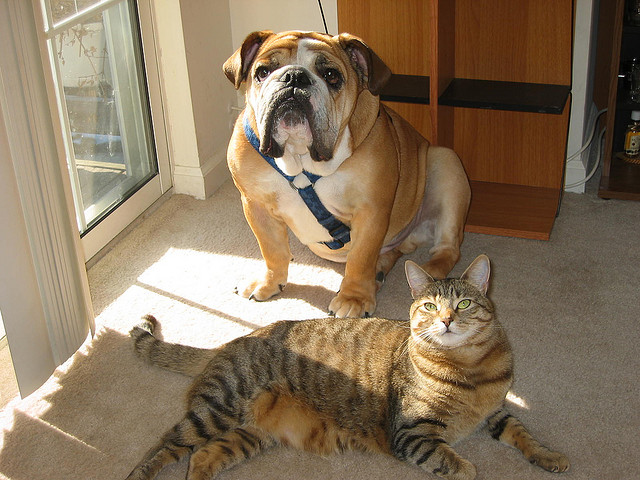

(640, 480, 'RGB')

In [5]:
image_path = os.path.join('../../', 'assets', 'cat_dog.jpg')
image_raw = Image.open(image_path).convert('RGB')
display(image_raw)
image_raw.width, image_raw.height, image_raw.mode

### 数据增强

In [6]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
])

inputs = transform(image_raw).unsqueeze(0)
inputs.shape

torch.Size([1, 3, 224, 224])

### 实现Vanilla Backpropagation (VBP)

$$
R_i^l = (f_i^l > 0) \cdot R_i^{l+1}, where R_i^{l+1} = \dfrac{\partial f^{out}}{\partial f_i^{l+1}}
$$

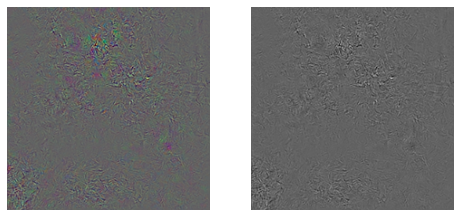

In [7]:
class VanillaBackpropagation():
    def __init__(self, model, input_image, target_class):
        self.model = model
        self.model.eval()
        self.input_image = input_image
        self.input_image.requires_grad_()
        self.target_class = target_class
        
        self.handlers = []
        self.f_maps = []
        
        for name, module in self.model.named_modules():
            if isinstance(module, torch.nn.ReLU):
                self.handlers.append(module.register_backward_hook(self.ibackward_hook()))
                self.handlers.append(module.register_forward_hook(self.iforward_hook()))
        
    def ibackward_hook(self):
        def relu_backward_hook(module, grad_in, grad_out):
            fmap = self.f_maps.pop()
            # 特征0-1矫正(f_i > 0)
            fmap[fmap > 0] = 1
            modified_grad_out = fmap * grad_in[0]
            return (modified_grad_out,)
        return relu_backward_hook

    def iforward_hook(self):
        def relu_forward_hook(module, _in, out):
            self.f_maps.append(out)
        return relu_forward_hook
    
    def remove_hook(self):
        self.input_image.grad.zero_()
        for handle in self.handlers:
            handle.remove()
        
    def generate_gradients(self):
        # Forward
        model_output = self.model(self.input_image)
        # Zero初始化梯度
        self.model.zero_grad()
        # One-Hot目标类
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][self.target_class] = 1
        # 反向传播
        model_output.backward(gradient=one_hot_output)
        # 返回转换为numpy类型并转置后的梯度
        return self.input_image.grad.clone().numpy()[0].transpose(1, 2, 0) # H, W, C
    
    @staticmethod
    def show(image_np):
        image_np -= np.min(image_np)
        image_np /= np.max(image_np)
        rgb = np.uint8(image_np * 255)
        gray = Image.fromarray(rgb).convert("LA")
        fig = plt.figure(figsize=(8, 8))
        fig.add_subplot(1, 2, 1).axis("off")
        plt.imshow(rgb)
        fig.add_subplot(1, 2, 2).axis("off")
        plt.imshow(gray);
        
model = models.resnet18(pretrained=True)
vbp = VanillaBackpropagation(model, inputs, 242)
vbp.show(vbp.generate_gradients())
vbp.remove_hook()

### 实现Deconvnet

$$
R_i^l = (R_i^{l+1} > 0) \cdot R_i^{l+1}, where R_i^{l+1} = \dfrac{\partial f^{out}}{\partial f_i^{l+1}}
$$

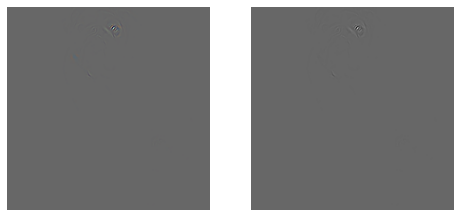

In [8]:
class Deconvnet(VanillaBackpropagation):
    def __init__(self, model, input_image, target_class):
        super(Deconvnet, self).__init__(model, input_image, target_class)
        
    def ibackward_hook(self):
        def relu_backward_hook(module, grad_in, grad_out):
            fmap = self.f_maps.pop()
            # 消除负梯度
            modified_grad = fmap * torch.clamp(grad_in[0], min=0.0)
            return (modified_grad,)
        return relu_backward_hook
    
deconv = Deconvnet(model, inputs, 242)
deconv.show(deconv.generate_gradients())
deconv.remove_hook()

### 实现Guided Backpropagation (GBP)

$$
R_i^l = (f_i^l > 0) (R_i^{l+1} > 0) \cdot R_i^{l+1}, where R_i^{l+1} = \dfrac{\partial f^{out}}{\partial f_i^{l+1}}
$$

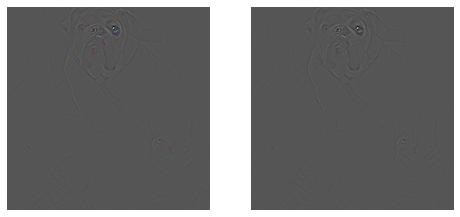

In [9]:
class GuidedBackpropagation(VanillaBackpropagation):
    def __init__(self, model, input_image, target_class):
        super(GuidedBackpropagation, self).__init__(model, input_image, target_class)
        
    def ibackward_hook(self):
        def relu_backward_hook(module, grad_in, grad_out):
            fmap = self.f_maps.pop()
            # 特征0-1矫正(f > 0)
            fmap[fmap > 0] = 1
            # 消除负梯度
            modified_grad = fmap * torch.clamp(grad_in[0], min=0.0)
            return (modified_grad,)
        return relu_backward_hook
                
model = models.resnet18(pretrained=True)
gbp = GuidedBackpropagation(model, inputs, 242)
gbp.show(gbp.generate_gradients())
gbp.remove_hook()

## 参考 

- [论文:Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/pdf/1312.6034.pdf)

- [论文:Visualizing and Understanding Convolutional Networks](https://arxiv.org/pdf/1311.2901.pdf)

- [论文:Striving for Simplicity: The All Convolutional Net](https://arxiv.org/pdf/1412.6806.pdf)

- [Gradient vs DevConnet vs GB](https://glassboxmedicine.com/2019/10/06/cnn-heat-maps-gradients-vs-deconvnets-vs-guided-backpropagation/)

- [Saliency Backpropagation](https://glassboxmedicine.com/2019/06/21/cnn-heat-maps-saliency-backpropagation/)

- https://github.com/utkuozbulak/pytorch-cnn-visualizations/

## 补充

颜色, 边缘, 轮廓, 文理, 神秘数字：142857


借助反卷积和导向反向传播的结果并不能拿来解释分类的结果，因为它们对类别并不敏感，直接把所有能提取的特征都展示出来了。
  
  
反卷积可视化以各层得到的特征图作为输入，进行反卷积，得到反卷积结果，用以验证显示各层提取到的特征图
  
  
deconvolution, is misinterpreted as reverse process of convolution, but it is not.And it is also called, up convolution, and transposed convolution.

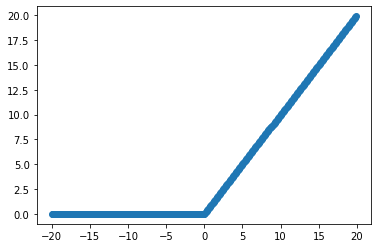

In [31]:
import torch
import matplotlib.pyplot as plt
from torch.nn import functional as F
xs = torch.arange(-20, 20, step=0.1)
ys = F.relu(xs)
plt.scatter(xs, ys);